This file simulates BB84 protocol specifically with Photon noise

In [1]:
!pip install qiskit[visualization] qiskit-ibm-runtime qiskit-aer qiskit_qasm3_import

import numpy as np
from qiskit import QuantumCircuit
from qiskit.quantum_info import Pauli, SparsePauliOp, Statevector
from qiskit.visualization import plot_histogram, plot_bloch_multivector
from qiskit_aer import AerSimulator
from qiskit.circuit import Parameter, ParameterVector
import qiskit.qasm3
from qiskit_ibm_runtime.fake_provider import FakeVigoV2
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import SamplerV2 as Sampler, EstimatorV2 as Estimator, QiskitRuntimeService
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit import IfElseOp, Instruction

#noise
from qiskit_aer.noise import NoiseModel, depolarizing_error, pauli_error
from qiskit_aer.noise import phase_damping_error
from qiskit_aer.noise import amplitude_damping_error

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import random

### Alice and Bob randomly generate different basis and the keys are being sent to BOB by alice

QC Function

In [3]:

#A_RNG_KEY  = RNG for key from ALice
#A_RNG_BASE = RNG for base from Alice
#B_RNG_BASE = RNG for BOBs base

def transmission(A_RNG_KEY,A_RNG_BASE,B_RNG_BASE):
  qc=QuantumCircuit(1,1)
  if(A_RNG_KEY==1):
    qc.x(0)
  if(A_RNG_BASE==1):
    qc.h(0)
  if(B_RNG_BASE==1):
    qc.h(0)
  qc.measure(0,0)
  return qc

In [4]:
n=512

a_bit=[np.random.randint(0,2) for i in range(n)]
a_base=[np.random.randint(0,2) for i in range(n)]
b_base=[np.random.randint(0,2) for i in range(n)]

b_bits={}
a_bits={}

# Create simulator and sampler once
sim_backend = AerSimulator()
pm = generate_preset_pass_manager(backend=sim_backend, optimization_level=1)
sampler = Sampler(mode=sim_backend)

for i in range(n):
    isa_qc = pm.run(transmission(a_bit[i], a_base[i], b_base[i]))
    job = sampler.run([isa_qc], shots=1)
    result = job.result()
    counts = result[0].data.c.get_counts()
    first_key = list(counts.keys())[0]
    b_bits[i] = int(first_key)
    a_bits[i]=a_bit[i]

print(b_bits)
print(a_bits)

diff_count = sum(1 for i in a_bits if a_bits[i] != b_bits[i])
print("fraction of bits which are not same for Alice and BoB=",diff_count/n)

{0: 0, 1: 0, 2: 0, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 1, 15: 0, 16: 0, 17: 1, 18: 1, 19: 0, 20: 1, 21: 0, 22: 1, 23: 1, 24: 0, 25: 0, 26: 1, 27: 0, 28: 1, 29: 1, 30: 0, 31: 1, 32: 1, 33: 0, 34: 1, 35: 1, 36: 0, 37: 0, 38: 1, 39: 0, 40: 0, 41: 0, 42: 0, 43: 0, 44: 0, 45: 1, 46: 1, 47: 1, 48: 1, 49: 0, 50: 0, 51: 0, 52: 1, 53: 0, 54: 0, 55: 0, 56: 1, 57: 0, 58: 1, 59: 1, 60: 0, 61: 1, 62: 1, 63: 0, 64: 1, 65: 0, 66: 1, 67: 1, 68: 0, 69: 0, 70: 0, 71: 0, 72: 1, 73: 0, 74: 0, 75: 1, 76: 0, 77: 1, 78: 0, 79: 0, 80: 1, 81: 0, 82: 1, 83: 0, 84: 1, 85: 0, 86: 1, 87: 0, 88: 0, 89: 1, 90: 1, 91: 1, 92: 0, 93: 0, 94: 0, 95: 0, 96: 1, 97: 1, 98: 1, 99: 0, 100: 0, 101: 0, 102: 0, 103: 1, 104: 0, 105: 1, 106: 1, 107: 0, 108: 0, 109: 1, 110: 1, 111: 0, 112: 1, 113: 0, 114: 0, 115: 0, 116: 0, 117: 0, 118: 1, 119: 0, 120: 1, 121: 1, 122: 0, 123: 0, 124: 1, 125: 1, 126: 1, 127: 0, 128: 0, 129: 1, 130: 0, 131: 0, 132: 1, 133: 1, 134: 1, 135: 0, 136: 0, 137: 1, 138: 

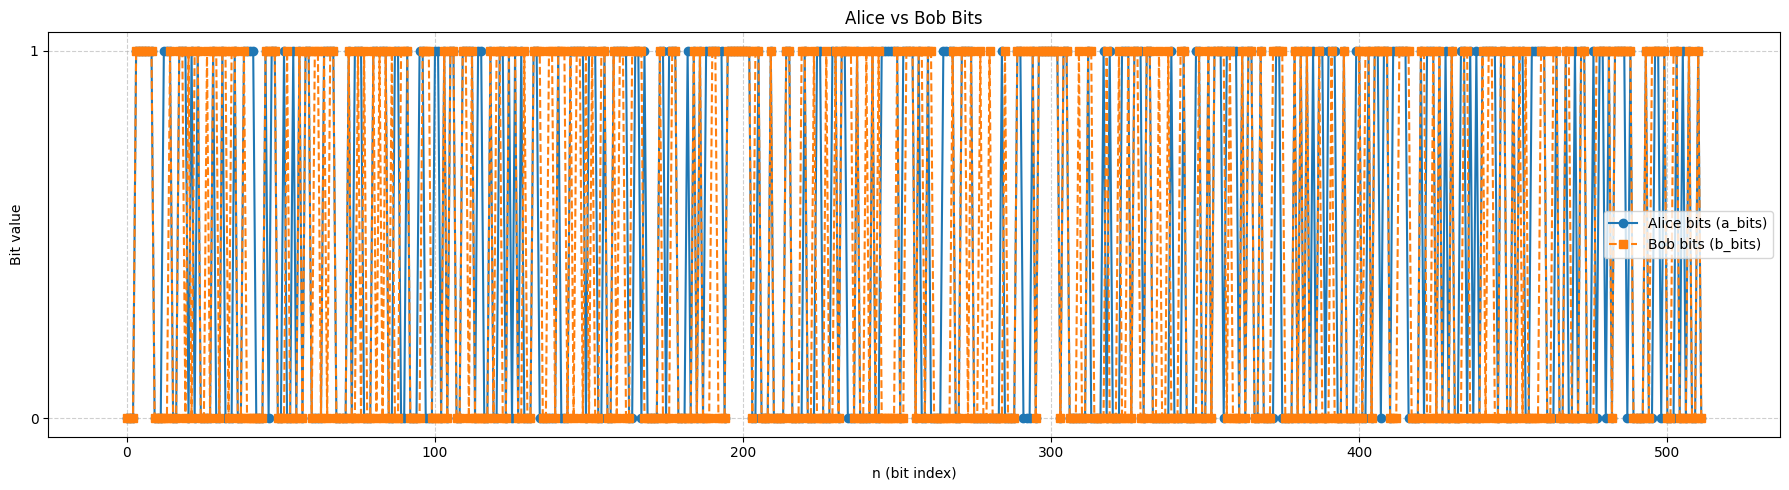

In [5]:
# Extract x (indices) and y (bit values)
x = list(a_bits.keys())
a_y = list(a_bits.values())
b_y = list(b_bits.values())

plt.figure(figsize=(18, 5))
plt.plot(x, a_y, 'o-', label='Alice bits (a_bits)')
plt.plot(x, b_y, 's--', label='Bob bits (b_bits)')

plt.title('Alice vs Bob Bits')
plt.xlabel('n (bit index)')
plt.ylabel('Bit value')
plt.yticks([0, 1])
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()

plt.show()


In [6]:
# Filter only where bases are equal
filtered_a_bits = {}
filtered_b_bits = {}

for i in range(len(a_base)):
    if a_base[i] == b_base[i]:
        filtered_a_bits[i] = a_bits[i]
        filtered_b_bits[i] = b_bits[i]

a_bits = filtered_a_bits
b_bits = filtered_b_bits

print("Filtered a_bits:", a_bits)
print("Filtered b_bits:", b_bits)
print("Number of matching bases:", len(a_bits))


Filtered a_bits: {1: 0, 2: 0, 3: 1, 4: 1, 5: 1, 7: 1, 8: 1, 9: 0, 10: 0, 11: 0, 15: 0, 18: 1, 23: 1, 25: 0, 27: 0, 31: 1, 33: 0, 35: 1, 37: 0, 43: 0, 45: 1, 47: 1, 49: 0, 50: 0, 53: 0, 56: 1, 57: 0, 58: 1, 59: 1, 63: 0, 64: 1, 66: 1, 67: 1, 68: 0, 69: 0, 71: 0, 73: 0, 78: 0, 82: 1, 84: 1, 91: 1, 92: 0, 94: 0, 96: 1, 99: 0, 102: 0, 105: 1, 107: 0, 110: 1, 117: 0, 123: 0, 126: 1, 130: 0, 132: 1, 133: 1, 139: 0, 144: 1, 146: 1, 147: 1, 151: 1, 153: 0, 157: 0, 158: 1, 160: 1, 161: 1, 163: 0, 165: 1, 169: 0, 172: 0, 178: 1, 179: 0, 180: 0, 185: 0, 186: 1, 187: 0, 190: 1, 191: 1, 194: 0, 199: 1, 201: 1, 203: 0, 205: 1, 206: 0, 207: 0, 208: 0, 211: 0, 213: 0, 214: 1, 215: 1, 216: 0, 217: 0, 218: 0, 221: 0, 222: 0, 226: 0, 228: 0, 231: 0, 237: 1, 238: 0, 239: 0, 241: 0, 242: 1, 250: 1, 254: 1, 255: 1, 256: 0, 257: 1, 260: 1, 262: 0, 263: 0, 268: 1, 271: 1, 272: 1, 275: 0, 276: 0, 278: 0, 279: 0, 282: 0, 286: 0, 289: 1, 296: 1, 298: 1, 299: 1, 300: 1, 301: 1, 304: 1, 305: 1, 306: 0, 308: 0, 310

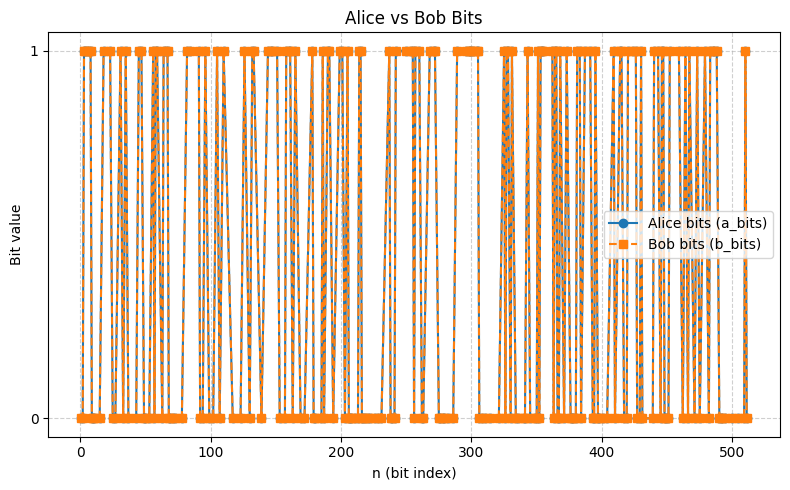

In [7]:
# Extract x (indices) and y (bit values)
x = list(a_bits.keys())
a_y = list(a_bits.values())
b_y = list(b_bits.values())

plt.figure(figsize=(8, 5))
plt.plot(x, a_y, 'o-', label='Alice bits (a_bits)')
plt.plot(x, b_y, 's--', label='Bob bits (b_bits)')

plt.title('Alice vs Bob Bits')
plt.xlabel('n (bit index)')
plt.ylabel('Bit value')
plt.yticks([0, 1])
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()

plt.show()

### Adding Noise in the gates and measurement errors and estimating QBER

In [8]:
#Parameters
n =512
noise_prob = 0.1 #10%noise

#Random bits and bases
a_bit = [np.random.randint(0, 2) for _ in range(n)]
a_base = [np.random.randint(0, 2) for _ in range(n)]
b_base = [np.random.randint(0, 2) for _ in range(n)]

noise_model = NoiseModel()

# Gate noise (depolarizing)
dep_error = depolarizing_error(noise_prob, 1)
noise_model.add_all_qubit_quantum_error(dep_error, ['x', 'h'])

# Measurement noise (bit flip)
meas_error = pauli_error([('X', noise_prob), ('I', 1 - noise_prob)])
noise_model.add_all_qubit_quantum_error(meas_error, ['measure'])

#photon noise
photon_loss_prob = 0.15  # 15% photon loss probability

#phase daming noise
phase_error_probab = 0.05
phase_error = phase_damping_error(phase_error_probab)
noise_model.add_all_qubit_quantum_error(phase_error, ['h'])

# Build noisy simulator
sim_backend = AerSimulator(noise_model=noise_model)
pm = generate_preset_pass_manager(backend=sim_backend, optimization_level=1)
sampler = Sampler(mode=sim_backend)

#Run simulation
b_bits = {}
a_bits = {}

for i in range(n):
    # simulate photon loss at classical level
    if np.random.rand() < photon_loss_prob: #15% chance of photon loss to Bob
        b_bits[i] = None
        a_bits[i] = a_bit[i]
        continue
    isa_qc = pm.run(transmission(a_bit[i], a_base[i], b_base[i]))
    job = sampler.run([isa_qc], shots=1)
    result = job.result()
    counts = result[0].data.c.get_counts()
    first_key = list(counts.keys())[0]
    b_bits[i] = int(first_key)
    a_bits[i] = a_bit[i]

#Measure raw disagreement
valid_indices = [i for i in a_bits if b_bits[i] is not None]
diff_count = sum(1 for i in valid_indices if a_bits[i] != b_bits[i])
print("No of mismatched bits (before basis filtering):", diff_count )
print("this is out of ",n," we got ",len(valid_indices))

No of mismatched bits (before basis filtering): 149
this is out of  512  we got  441


### Sifting phase of protocol

In [9]:
filtered_a_bits = {}
filtered_b_bits = {}
matching_indices= []

for i in range(len(a_base)):
    if a_base[i] == b_base[i]:
        matching_indices.append(i)
        filtered_a_bits[i] = a_bits[i]
        filtered_b_bits[i] = b_bits[i]

a_bits = filtered_a_bits
b_bits = filtered_b_bits

print("Filtered a_bits:", a_bits)
print("Filtered b_bits:", b_bits)
print("Number of matching bases:", len(a_bits))

Filtered a_bits: {0: 0, 1: 0, 2: 1, 4: 1, 6: 0, 12: 1, 14: 1, 16: 0, 17: 0, 19: 0, 23: 0, 24: 0, 26: 1, 27: 0, 28: 1, 31: 0, 32: 0, 33: 1, 36: 0, 37: 0, 38: 0, 42: 1, 45: 0, 46: 1, 49: 0, 50: 1, 53: 1, 54: 1, 56: 0, 57: 1, 60: 1, 61: 0, 62: 1, 65: 0, 67: 0, 68: 1, 71: 0, 72: 1, 75: 1, 76: 0, 80: 0, 82: 1, 83: 0, 89: 0, 90: 1, 91: 0, 92: 0, 95: 1, 97: 1, 98: 1, 101: 1, 102: 1, 104: 0, 107: 1, 111: 0, 112: 1, 113: 1, 117: 1, 118: 0, 119: 1, 121: 0, 123: 1, 124: 0, 125: 0, 126: 0, 129: 0, 130: 0, 131: 0, 133: 1, 134: 1, 135: 0, 138: 1, 140: 1, 142: 0, 146: 0, 148: 1, 149: 0, 150: 0, 151: 1, 153: 1, 154: 0, 156: 1, 157: 0, 161: 0, 164: 0, 169: 0, 171: 1, 172: 0, 173: 1, 176: 1, 182: 0, 183: 1, 184: 0, 185: 0, 188: 1, 189: 1, 191: 0, 192: 1, 194: 1, 197: 0, 199: 0, 203: 0, 207: 1, 208: 1, 210: 1, 211: 1, 212: 1, 214: 0, 216: 0, 217: 0, 218: 0, 221: 1, 225: 1, 227: 0, 228: 1, 229: 1, 231: 0, 232: 1, 233: 1, 234: 0, 238: 1, 240: 1, 241: 1, 242: 1, 244: 1, 245: 0, 246: 0, 247: 1, 248: 1, 249: 

# QBER Estimation between Alice and Bob, Here i am looking at the mean and standard deviation




Actual QBER (including photon loss) = 0.2453
Errors due to bit mismatch = 32
Errors due to photon loss  = 33
Total matching bases       = 265

Average estimated QBER = 0.2454 ± 0.0245


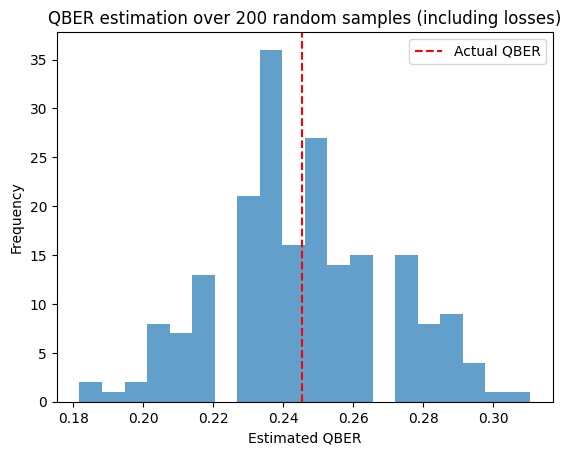


Final key length after discarding losses: 232 bits


In [10]:
#Compute QBER including photon losses

total_matched = len(matching_indices)

# Count mismatches or photon losses
error_count = 0
lost_count = 0

for i in matching_indices:
    if b_bits[i] is None:
        lost_count += 1
        error_count += 1  # treat loss as an error for QBER estimate
    elif a_bits[i] != b_bits[i]:
        error_count += 1

actual_qber = error_count / total_matched
print(f"Actual QBER (including photon loss) = {actual_qber:.4f}")
print(f"Errors due to bit mismatch = {error_count - lost_count}")
print(f"Errors due to photon loss  = {lost_count}")
print(f"Total matching bases       = {total_matched}")

#Estimate QBER variability using random sampling
subset = 0.5
sample_size = int(subset * total_matched)
num_trials = 200
estimates = []

for _ in range(num_trials):
    sample_indices = random.sample(matching_indices, sample_size)
    sample_errors = 0
    for i in sample_indices:
        if b_bits[i] is None or a_bits[i] != b_bits[i]:
            sample_errors += 1
    qber_estimate = sample_errors / sample_size
    estimates.append(qber_estimate)

mean_estimate = np.mean(estimates)
std_estimate = np.std(estimates)

print(f"\nAverage estimated QBER = {mean_estimate:.4f} ± {std_estimate:.4f}")

plt.hist(estimates, bins=20, alpha=0.7)
plt.axvline(actual_qber, color='red', linestyle='--', label='Actual QBER')
plt.title(f"QBER estimation over {num_trials} random samples (including losses)")
plt.xlabel("Estimated QBER")
plt.ylabel("Frequency")
plt.legend()
plt.show()

#Bob announces photon losses; Alice removes corresponding bits
valid_indices = [i for i in matching_indices if b_bits[i] is not None]
lost_indices = [i for i in matching_indices if b_bits[i] is None]
matching_indices=valid_indices

for i in lost_indices:
    a_bits.pop(i, None)
    b_bits.pop(i, None)

print(f"\nFinal key length after discarding losses: {len(a_bits)} bits")


# Discarding the bits used to calculate QBER and Moving to Error Correction

In [11]:
#Bob announces photon losses; Alice removes corresponding bits
valid_indices = [i for i in matching_indices if b_bits[i] is not None]
lost_indices = [i for i in matching_indices if b_bits[i] is None]

matching_indices=valid_indices

for i in lost_indices:
    a_bits.pop(i, None)
    b_bits.pop(i, None)

#alice anounces subset no of bits to BOB

subset = 0.5  #50% of matching bits used for estimation
sample_size = int(subset * len(matching_indices))

sample_indices = random.sample(matching_indices, sample_size)
qber_estimate = sum(a_bits[i] != b_bits[i] for i in sample_indices) / sample_size

for i in sample_indices:
    a_bits.pop(i, None)
    b_bits.pop(i, None)

print(f"Remaining bits after QBER estimation: {len(a_bits)}")

# Convert remaining bits to key lists (ordered by index for consistency)
remaining_indices = sorted(a_bits.keys())
A_keys = [a_bits[i] for i in remaining_indices]
B_keys = [b_bits[i] for i in remaining_indices]

print("Alice's final key:", A_keys)
print("Bob's final key:  ", B_keys)

Remaining bits after QBER estimation: 116
Alice's final key: [1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0]
Bob's final key:   [1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0]


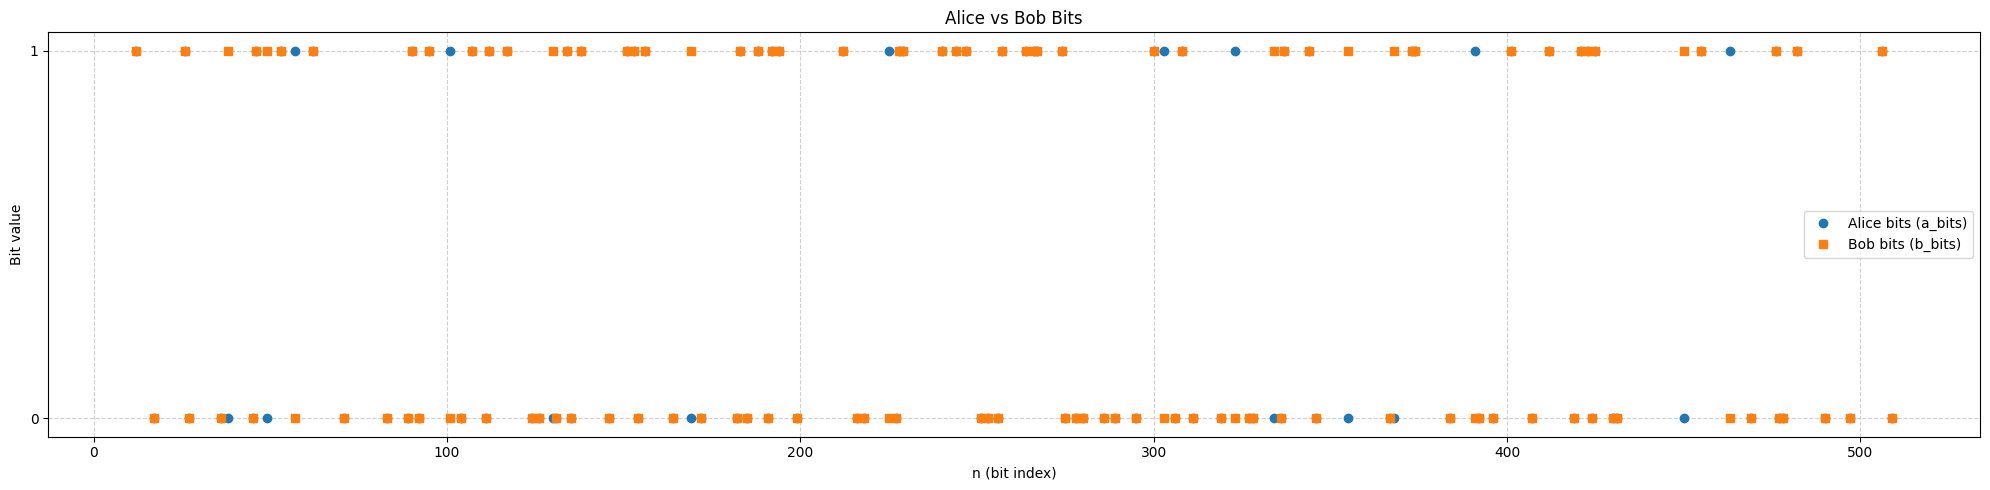

In [12]:
# Extract x (indices) and y (bit values)
x = list(a_bits.keys())
a_y = list(a_bits.values())
b_y = list(b_bits.values())

plt.figure(figsize=(20, 5))
plt.plot(x, a_y, 'o', label='Alice bits (a_bits)')
plt.plot(x, b_y, 's', label='Bob bits (b_bits)')

plt.title('Alice vs Bob Bits')
plt.xlabel('n (bit index)')
plt.ylabel('Bit value')
plt.yticks([0, 1])
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()

plt.show()

# Error Reconcilation Using Cascade Protocol

In [13]:
def cascade(A_key, B_key):

    N = len(A_key)
    B_key = B_key.copy()  # avoid in-place modification of input

    # Step 1: Divide into blocks
    B_size = int(1/qber_estimate)  # block size
    blocks_A = []
    blocks_B = []

    for start in range(0, len(A_key), B_size):
        end = start + B_size
        blocks_A.append(A_key[start:end])
        blocks_B.append(B_key[start:end])
    parity_A=[(sum(i))%2 for i in blocks_A]
    parity_B=[(sum(i)%2) for i in blocks_B]
        # Step 2: If mismatch, binary search within the block
    for i in range(len(parity_A)):
        if parity_A[i] != parity_B[i]:
            left, right = 0, len(blocks_B[i])
            while left < right:
                mid = (left + right) // 2
                pA = sum(blocks_A[i][left:mid+1]) % 2
                pB = sum(blocks_B[i][left:mid+1]) % 2
                if pA != pB:
                    right = mid  # error is in left half
                else:
                    left = mid + 1  # error is in right half

            B_key[left] = A_key[left]
    return B_key


# Performing Multiple Iterations of Shuffling and Parity Checking

In [14]:
import random

# assume you already have A_key and B_key from sifting
b_1=B_keys.copy()

for i in range(1000):
    indices = list(range(len(A_keys)))
    random.shuffle(indices)

    #Apply the same permutation
    A_shuffled = [A_keys[j] for j in indices]
    B_shuffled = [b_1[j] for j in indices]

    #Run Cascade on shuffled keys
    corrected_shuffled = cascade(A_shuffled, B_shuffled)

    #Unshuffle back to original order
    unshuffled = [0] * len(A_keys)
    for new_pos, old_pos in enumerate(indices):
        unshuffled[old_pos] = corrected_shuffled[new_pos]

    #Update b for next pass
    b_1 = unshuffled

# After all passes:
print("Final corrected key:", b_1)
print("Errors remaining:", sum(x != y for x, y in zip(A_keys, b_1)))


Final corrected key: [1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0]
Errors remaining: 0


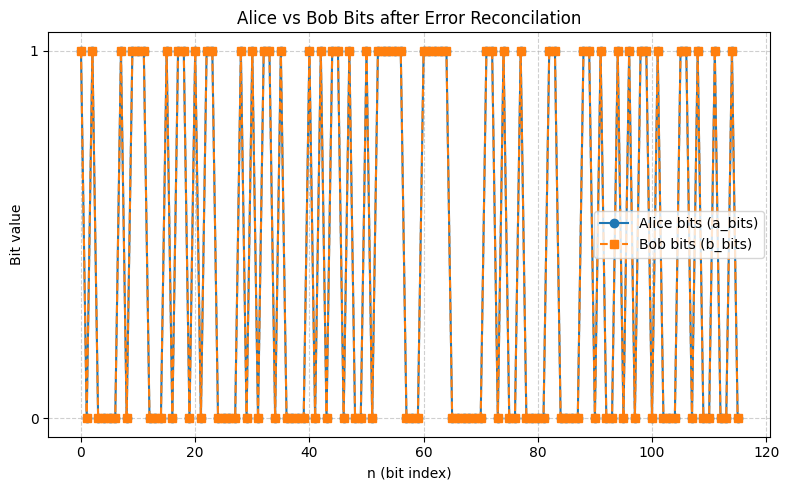

In [15]:
x = [i for i in range(len(A_keys))]
a_y = A_keys
b_y = b_1

# Plot both
plt.figure(figsize=(8, 5))
plt.plot(x, a_y, 'o-', label='Alice bits (a_bits)')
plt.plot(x, b_y, 's--', label='Bob bits (b_bits)')

# Customize
plt.title('Alice vs Bob Bits after Error Reconcilation')
plt.xlabel('n (bit index)')
plt.ylabel('Bit value')
plt.yticks([0, 1])
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()

# Show the plot
plt.show()